# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [10]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import brown
from collections import Counter, defaultdict

In [11]:
# Load the Brown corpus
nltk.download('brown')
words = brown.words()
N = len(words)
print(f"Total words in corpus: {N}")

[nltk_data] Downloading package brown to
[nltk_data]     /Users/polinakorobeinikova/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Total words in corpus: 1161192


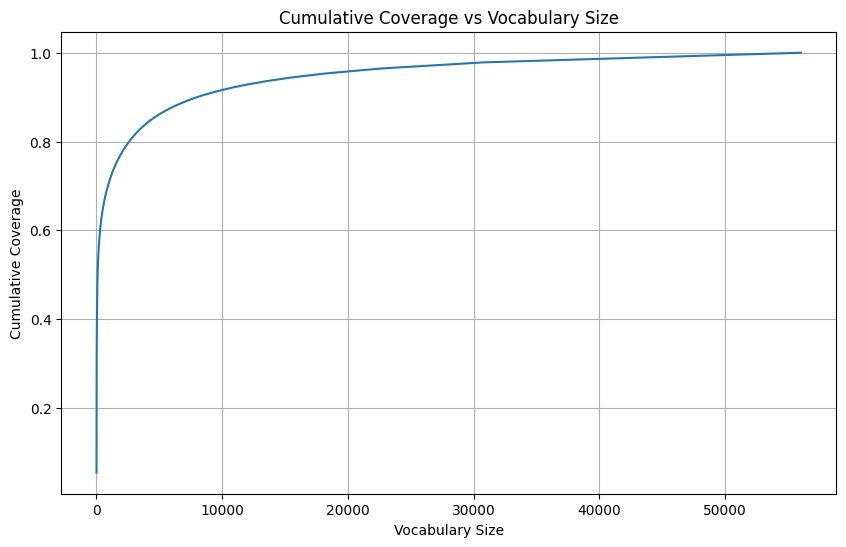

In [12]:
# Calculate word frequencies
fdist = nltk.FreqDist(words)
# Sort words by frequency (descending)
sorted_words = fdist.most_common()

# Plot cumulative coverage vs. vocabulary size
frequencies = np.array([freq for word, freq in sorted_words])
cumulative_coverage = np.cumsum(frequencies) / N

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(frequencies) + 1), cumulative_coverage)
plt.xlabel("Vocabulary Size")
plt.ylabel("Cumulative Coverage")
plt.title("Cumulative Coverage vs Vocabulary Size")
plt.grid(True)
plt.show()

In [13]:
# Select the appropriate vocabulary size (coverage >= 0.9)
target_coverage = 0.9
vocab_size_90 = np.argmax(cumulative_coverage >= target_coverage) + 1
print(f"Vocabulary size covering 90% of the corpus: {vocab_size_90}")

Vocabulary size covering 90% of the corpus: 8012


**Answers:**
1. The coverage growth slows down because the most frequent words (top ranks) account for the vast majority of the text. As we increase the vocabulary size, we add progressively rarer words. Each new rare word appears very few times, so its contribution to the total coverage is minimal compared to the top-ranked words.
2. It is Zipf's Law. It states that word frequency is inversely proportional to its rank.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [14]:
class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) Tokenizer implementation.
    
    BPE iteratively merges the most frequent pair of tokens in the corpus
    until reaching the desired vocabulary size.
    """
    
    def __init__(self, vocab_size):
        """
        Initialize the BPE tokenizer.
        
        Args:
            vocab_size (int): Target vocabulary size
        """
        self.vocab_size = vocab_size
        self.merges = {}  # Dictionary to store merge operations
        self.vocab = set()  # Set of all tokens in vocabulary
        
    def _get_word_freqs(self, corpus):
        """
        Calculate word frequencies in the corpus.
        
        Args:
            corpus (list): List of words
            
        Returns:
            dict: Dictionary mapping words to their frequencies
        """
        return Counter(corpus)
    
    def _get_stats(self, word_freqs):
        """
        Count frequencies of adjacent token pairs.
        
        Args:
            word_freqs (dict): Dictionary with words split into characters and their frequencies
            
        Returns:
            dict: Dictionary mapping pairs of tokens to their frequency
        """
        pairs = defaultdict(int)
        
        for word, freq in word_freqs.items():
            symbols = word.split()
            
            # Count all adjacent pairs in this word
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
                
        return pairs
    
    def _merge_pair(self, pair, word_freqs):
        """
        Merge all occurrences of a token pair in the vocabulary.
        
        Args:
            pair (tuple): Pair of tokens to merge
            word_freqs (dict): Current word frequencies
            
        Returns:
            dict: Updated word frequencies after merge
        """
        new_word_freqs = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        
        for word, freq in word_freqs.items():
            # Replace the pair with merged token
            new_word = word.replace(bigram, replacement)
            new_word_freqs[new_word] = freq
            
        return new_word_freqs
    
    def train(self, corpus):
        """
        Train the BPE tokenizer on a corpus.
        
        The algorithm:
        1. Split each word into characters
        2. Find the most frequent pair of adjacent tokens
        3. Merge this pair into a single token
        4. Repeat until vocabulary size is reached
        
        Args:
            corpus (list): List of words to train on
        """
        # Step 1: Get word frequencies
        word_freqs = self._get_word_freqs(corpus)
        
        # Step 2: Split words into characters with space separation
        # Add end-of-word marker </w> to distinguish word boundaries
        word_freqs = {' '.join(word) + ' </w>': freq 
                      for word, freq in word_freqs.items()}
        
        # Initialize vocabulary with all individual characters
        self.vocab = set()
        for word in word_freqs.keys():
            self.vocab.update(word.split())
        
        # Step 3: Perform merges until reaching target vocabulary size
        num_merges = self.vocab_size - len(self.vocab)
        
        for i in range(num_merges):
            # Find most frequent pair
            pairs = self._get_stats(word_freqs)
            
            if not pairs:
                break
                
            # Get the most common pair
            best_pair = max(pairs, key=pairs.get)
            
            # Merge the pair
            word_freqs = self._merge_pair(best_pair, word_freqs)
            
            # Store the merge operation
            self.merges[best_pair] = i
            
            # Add merged token to vocabulary
            self.vocab.add(''.join(best_pair))
            
            if (i + 1) % 500 == 0:
                print(f"Completed {i + 1}/{num_merges} merges")
    
    def tokenize(self, text):
        """
        Tokenize text using trained BPE model.
        
        Args:
            text (str): Input text to tokenize
            
        Returns:
            list: List of tokens
        """
        # Pre-tokenization: split by whitespace
        words = text.lower().split()
        
        tokens = []
        
        for word in words:
            # Split word into characters and add end-of-word marker
            word = ' '.join(word) + ' </w>'
            
            # Apply learned merges in order
            while True:
                # Get all pairs in current word
                pairs = []
                symbols = word.split()
                
                for i in range(len(symbols) - 1):
                    pairs.append((symbols[i], symbols[i + 1]))
                
                if not pairs:
                    break
                
                # Find the pair with lowest merge index (applied earliest in training)
                # If pair not in merges, it won't be merged
                bigram = min(pairs, key=lambda pair: self.merges.get(pair, float('inf')))
                
                # If this pair was never merged during training, stop
                if bigram not in self.merges:
                    break
                
                # Merge the pair
                first, second = bigram
                new_word = []
                i = 0
                symbols = word.split()
                
                while i < len(symbols):
                    if i < len(symbols) - 1 and symbols[i] == first and symbols[i + 1] == second:
                        new_word.append(first + second)
                        i += 2
                    else:
                        new_word.append(symbols[i])
                        i += 1
                
                word = ' '.join(new_word)
            
            # Add final tokens to result
            tokens.extend(word.split())
        
        return tokens


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [15]:
# Train the tokenizer
print("Training BPE tokenizer...")
tokenizer = BPETokenizer(vocab_size=vocab_size_90)

# Get all words from Brown corpus
corpus_words = [word.lower() for word in brown.words()]

# Train the tokenizer
tokenizer.train(corpus_words)
print(f"Training complete! Vocabulary size: {len(tokenizer.vocab)}")

Training BPE tokenizer...
Completed 500/7954 merges
Completed 1000/7954 merges
Completed 1500/7954 merges
Completed 2000/7954 merges
Completed 2500/7954 merges
Completed 3000/7954 merges
Completed 3500/7954 merges
Completed 4000/7954 merges
Completed 4500/7954 merges
Completed 5000/7954 merges
Completed 5500/7954 merges
Completed 6000/7954 merges
Completed 6500/7954 merges
Completed 7000/7954 merges
Completed 7500/7954 merges
Training complete! Vocabulary size: 8012


In [16]:
# Calculate fertility and tokenized sentence length
print("Calculating metrics on 1000 samples...")

# Get 1000 sentences from Brown corpus
sentences = brown.sents()[:1000]

fertilities = []
tokenized_lengths = []

for sentence in sentences:
    # Join sentence into text
    text = ' '.join(sentence).lower()
    
    # Tokenize
    tokens = tokenizer.tokenize(text)
    
    # Calculate fertility: number of tokens / number of characters (excluding spaces)
    char_count = len(text.replace(' ', ''))
    token_count = len(tokens)
    
    if char_count > 0:
        fertility = token_count / char_count
        fertilities.append(fertility)
    
    # Store tokenized sentence length
    tokenized_lengths.append(token_count)

# Calculate statistics
mean_fertility = np.mean(fertilities)
std_fertility = np.std(fertilities)

mean_length = np.mean(tokenized_lengths)
std_length = np.std(tokenized_lengths)

print(f"\nTokenizer Fertility:")
print(f"  Mean: {mean_fertility:.4f}")
print(f"  Std:  {std_fertility:.4f}")

print(f"\nTokenized Sentence Length:")
print(f"  Mean: {mean_length:.2f} tokens")
print(f"  Std:  {std_length:.2f} tokens")

Calculating metrics on 1000 samples...

Tokenizer Fertility:
  Mean: 0.5015
  Std:  0.0670

Tokenized Sentence Length:
  Mean: 49.67 tokens
  Std:  28.20 tokens


In [17]:
# Test tokenization on example
example_text = "the quick brown fox jumps over the lazy dog"
example_tokens = tokenizer.tokenize(example_text)
print(f"\nExample tokenization:")
print(f"Text: '{example_text}'")
print(f"Tokens: {example_tokens}")


Example tokenization:
Text: 'the quick brown fox jumps over the lazy dog'
Tokens: ['the</w>', 'qu', 'ic', 'k</w>', 'bro', 'wn</w>', 'fo', 'x</w>', 'ju', 'm', 'ps</w>', 'o', 'v', 'er</w>', 'the</w>', 'la', 'z', 'y</w>', 'dog</w>']


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.